# Machine Learning Model

**Author:** Florian Klaver  

In this Jupyter Notebook the machine learning models to classify between mowed and not mowed are trained and evaluated.

---
## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, auc, f1_score, precision_score, recall_score
)
from lightgbm import LGBMClassifier
import joblib

In [2]:
data = pd.read_csv('../data/training_samples_all_indices.csv')
print(f"Loaded {len(data)} total samples.")

Loaded 33368 total samples.


---
## Preparation

The logic assumption would be that the differences in the vegetation indices are the most important features to detect the mowing event. Therefore the question might arise, why keep all these additional features such as blue_after, red_after etc. if they are not important? Right now this is only an assumption and there may also be additional connections between the features which can help the model to detect the right class. To test this, a correlation matrix is plotted to analyse how the features interact with eachother and the target label. Additionally a model-based feature selection is used to find the most important features. With this analysis it is then possible to simplify the model by only keeping the the features with the highest impact on the prediction.

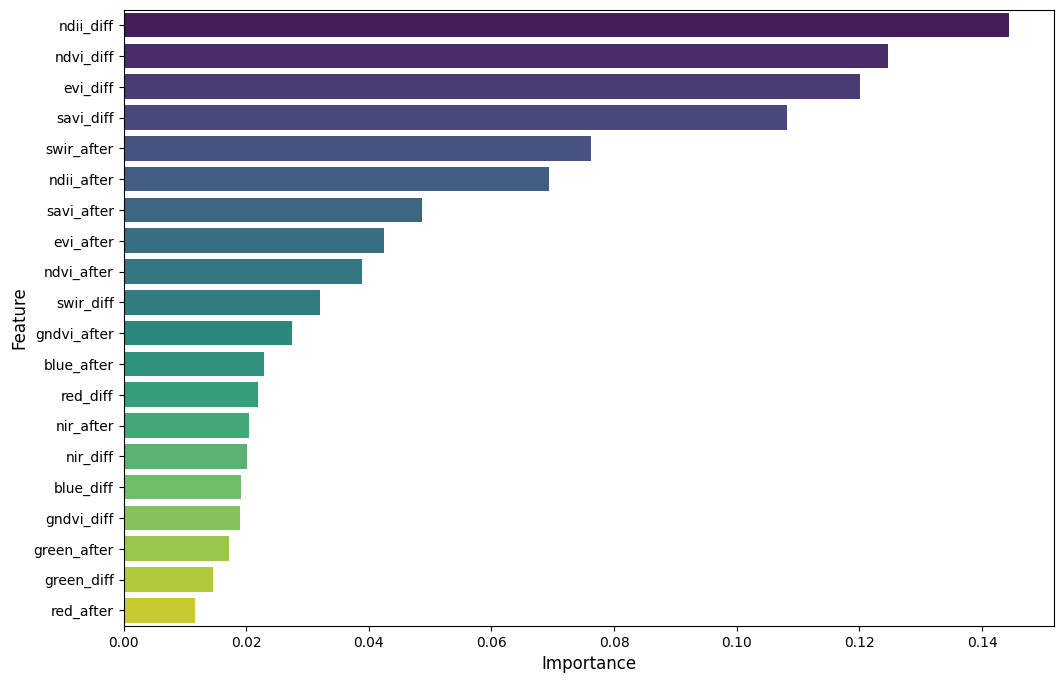

In [ ]:
# Define features (X) and target (y) 
# Drop the target 'label' AND all non-feature columns
X = data.drop(columns=['label', 'x', 'y', 'event_date', 'match_id'])
y = data['label']

# Train Random Forest 
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X, y)

# Extract and plot feature importances 
importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, 
            palette='viridis', hue='Feature', legend=False)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
#plt.title('Feature Importance (Random Forest)', fontsize=16)
plt.savefig('../docs/images/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

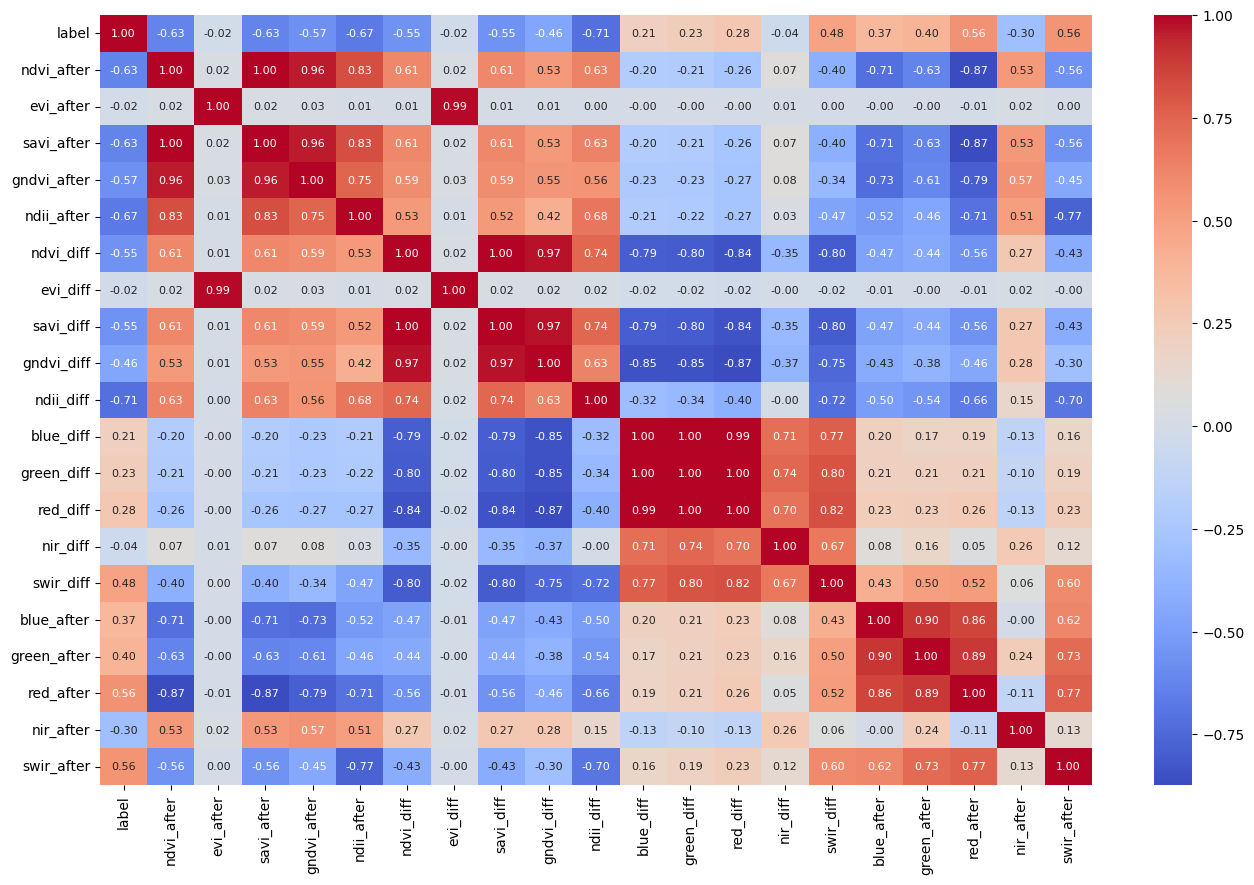

In [4]:
# Select only the features and the target
plot_data = data.drop(columns=['x', 'y', 'event_date', 'match_id'])

# Calculate the correlation matrix
corr_matrix = plot_data.corr()

# Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            annot_kws={"size": 8})
#plt.title('Feature Correlation Matrix (including target "label")', fontsize=20, pad=20)
plt.savefig('../docs/images/feature_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

---
## Functions

### Helper Functions

In [ ]:
# Data Preparation Function
def prepare_data(data, features_to_keep, random_state=42):
    """
    Selects features and performs a Group-based Train/Test split.
    Returns train and test sets along with group information.
    """
    print(f"\n--- Preparing Data with {len(features_to_keep)} Features ---")
    
    # Filter features
    available_features = [f for f in features_to_keep if f in data.columns]
    if len(available_features) < len(features_to_keep):
        print(f"Warning: Missing features. Using: {available_features}")
    
    X = data[available_features]
    y = data['label']
    groups = data['match_id']

    # Group Shuffle Split (Prevent Leakage)
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    train_idx, test_idx = next(gss.split(X, y, groups))

    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    groups_train = groups.iloc[train_idx] # Needed for GridSearch CV

    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]

    print(f"Training samples: {len(X_train)} ({groups.iloc[train_idx].nunique()} matches)")
    print(f"Testing samples:  {len(X_test)} ({groups.iloc[test_idx].nunique()} matches)")
    
    return X_train, y_train, groups_train, X_test, y_test

In [ ]:
# Evaluation Helper Function
def evaluate_model(model, X_test, y_test, model_name="Model", color="darkorange", results_list=None):
    """
    Standard evaluation pipeline: Report, Confusion Matrix, ROC Curve.
    Returns Classification report, CConfusion matrix and ROC curve
    """
    print(f"\n--- Evaluation: {model_name} ---")
    
    # Predictions
    y_pred = model.predict(X_test)

    # Check if model supports probability prediction (for SVM)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # Fallback for SVMs trained without probability=True (uses decision function)
        y_proba = model.decision_function(X_test)
    
    # Accuracy and Report
    score = model.score(X_test, y_test)
    print(f'Accuracy: {score * 100:.2f}%')
    class_labels = ["Not Mowed (0)", "Mowed (1)"]
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, target_names=class_labels))


    # Calculate and Store Metrics in results_list
    if results_list is not None:
        # Calculate confusion matrix components
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        # Calculate scores
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Get feature names safely
        features_used = list(X_test.columns) if hasattr(X_test, 'columns') else "Unknown"

        # Append to the external list
        results_list.append({
            "Model": model_name,
            "Features": features_used,
            "Num_Features": len(features_used) if isinstance(features_used, list) else 0,
            "Accuracy": score,
            "Precision": precision,  
            "Recall": recall,        
            "F1_Score": f1,
            "ROC_AUC": float(f"{auc(roc_curve(y_test, y_proba)[0], roc_curve(y_test, y_proba)[1]):.3f}"),
            "TP": tp,
            "TN": tn,
            "FP": fp,
            "FN": fn
        })

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, display_labels=class_labels, 
        cmap="Blues", xticks_rotation='horizontal', ax=ax1, colorbar=False
    )
    #ax1.set_title(f"Confusion Matrix - {model_name}")
    # adjust font size inside the confusion matrix
    for t in ax1.texts:
        t.set_fontsize(11)
    # adjust axis tick label font size
    ax1.xaxis.label.set_size(14)
    ax1.yaxis.label.set_size(14)  
    # adjust tick labels size
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.grid(False)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    ax2.plot(fpr, tpr, color=color, lw=2, label=f"AUC = {roc_auc:.3f}")
    ax2.plot([0, 1], [0, 1], color="navy", linestyle="--", label="Chance (0.5)")
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    #ax2.set_title(f"ROC Curve - {model_name}")
    ax2.xaxis.label.set_size(14)
    ax2.yaxis.label.set_size(14)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.legend(loc="lower right")
    ax2.grid(True)

    plt.tight_layout()
    safe_name = model_name.lower().replace(" ", "_").replace("(", "").replace(")", "")
    save_path = f'../docs/images/models/{safe_name}_evaluation.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return score, roc_auc

### Model Functions

In [7]:
# Baseline Random Forest Model
def train_baseline_rf(X_train, y_train, X_test, y_test, results_list=None, model_alias="Baseline RF"):
    print("\nTRAINING: Baseline Random Forest...")
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    evaluate_model(rf, X_test, y_test, model_name=model_alias, color="darkorange", results_list=results_list)
    return rf

In [8]:
# Tuned Random Forest Model with GridSearchCV
def train_tuned_rf(X_train, y_train, groups_train, X_test, y_test, param_grid, results_list=None, model_alias="Tuned RF"):
    print("\nTRAINING: Tuned Random Forest (GridSearch)...")
    
    pipeline = Pipeline([('rf', RandomForestClassifier(random_state=42, n_jobs=-1))])
    group_kfold = GroupKFold(n_splits=5)
    
    grid = GridSearchCV(
        pipeline, param_grid, cv=group_kfold, 
        scoring='accuracy', n_jobs=-1, verbose=1
    )
    grid.fit(X_train, y_train, groups=groups_train)
    
    print("Best Parameters:", grid.best_params_)
    evaluate_model(grid.best_estimator_, X_test, y_test, model_name=model_alias, color="darkorange", results_list=results_list)
    return grid.best_estimator_

In [9]:
# Baseline LightGBM Model
def train_baseline_lgbm(X_train, y_train, X_test, y_test, results_list=None, model_alias="Baseline LGBM"):
    print("\nTRAINING: Baseline LightGBM...")
    lgbm = LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
    lgbm.fit(X_train, y_train)
    
    evaluate_model(lgbm, X_test, y_test, model_name=model_alias, color="green", results_list=results_list)
    return lgbm

In [10]:
# Tuned LightGBM Model with GridSearchCV
def train_tuned_lgbm(X_train, y_train, groups_train, X_test, y_test, param_grid, results_list=None, model_alias="Tuned LGBM"):
    print("\nTRAINING: Tuned LightGBM (GridSearch)...")
    
    pipeline = Pipeline([('lgbm', LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1))])
    group_kfold = GroupKFold(n_splits=5)
    
    grid = GridSearchCV(
        pipeline, param_grid, cv=group_kfold, 
        scoring='accuracy', n_jobs=-1, verbose=1
    )
    grid.fit(X_train, y_train, groups=groups_train)
    
    print("Best Parameters:", grid.best_params_)
    evaluate_model(grid.best_estimator_, X_test, y_test, model_name=model_alias, color="green", results_list=results_list)
    return grid.best_estimator_

In [ ]:
# Baseline SVM Model
def train_baseline_svm(X_train, y_train, X_test, y_test, results_list=None, model_alias="Baseline SVM"):
    print("\nTRAINING: Baseline SVM...")

    # Probability=True is needed for ROC curves
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('svm', SVC(probability=True, random_state=42))
    ])
    
    pipeline.fit(X_train, y_train)
    
    evaluate_model(pipeline, X_test, y_test, model_name=model_alias, color="purple", results_list=results_list)
    return pipeline

In [ ]:
# Tuned SVM Model with GridSearchCV
def train_tuned_svm(X_train, y_train, groups_train, X_test, y_test, param_grid, results_list=None, model_alias="Tuned SVM"):
    print("\nTRAINING: Tuned SVM (GridSearch)...")
    
    # Scaling is mandatory for SVM
    # Probability=True is needed for ROC curves
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('svm', SVC(probability=True, random_state=42))
    ])
    
    param_grid = param_grid
    
    group_kfold = GroupKFold(n_splits=5)
    
    grid = GridSearchCV(
        pipeline, param_grid, cv=group_kfold, 
        scoring='accuracy', n_jobs=-1, verbose=1
    )
    grid.fit(X_train, y_train, groups=groups_train)
    
    print("Best Parameters:", grid.best_params_)
    evaluate_model(grid.best_estimator_, X_test, y_test, model_name=model_alias, color="purple", results_list=results_list)
    return grid.best_estimator_

---
## Train and Evaluate Models

In this section the model functions are applied with different features (single features and feature combinations) to evaluate model performance based on both feature selection and model complexity. The feature selection is based on the correlation matrix and feature importance evaluation above.

In [13]:
# Parameter Grid Random Forest
rf_params = {
    'rf__n_estimators': [100, 300, 500],
    'rf__max_depth': [None, 20],
    'rf__min_samples_split': [2, 10],
    'rf__min_samples_leaf': [1, 4]
}

# Parameter grid LGBM
lgbm_params = {
    'lgbm__n_estimators': [100, 200],         
    'lgbm__learning_rate': [0.05, 0.1],    
    'lgbm__num_leaves': [31, 50],          
    'lgbm__max_depth': [-1, 10]           
}

# Parameter grid SVM
svm_params = {
    'svm__C': [0.1, 1, 10, 100], 
    'svm__gamma': ['scale', 'auto', 0.1, 0.01], 
    'svm__kernel': ['rbf'] 
}


# Initialize results list
model_results = []

---
### ndii_diff  
The difference of the NDII index shows both the strongest correlation and feature importance with the label based on the analysis above. Therefore the first model runs are conducted only with this vegetation index.


In [ ]:
# Features to use
FEATURES_TO_KEEP_ndii = ['ndii_diff']

# Prepare data for NDII feature
X_train_ndii, y_train_ndii, groups_train_ndii, X_test_ndii, y_test_ndii = prepare_data(data, FEATURES_TO_KEEP_ndii)


--- Preparing Data with 1 Features ---
Training samples: 24945 (50 matches)
Testing samples:  8423 (13 matches)


#### Baseline Random Forest


TRAINING: Baseline Random Forest...

--- Evaluation: Baseline RF (NDII) ---
Accuracy: 86.18%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.82      0.88      0.85      3702
    Mowed (1)       0.90      0.85      0.87      4721

     accuracy                           0.86      8423
    macro avg       0.86      0.86      0.86      8423
 weighted avg       0.86      0.86      0.86      8423



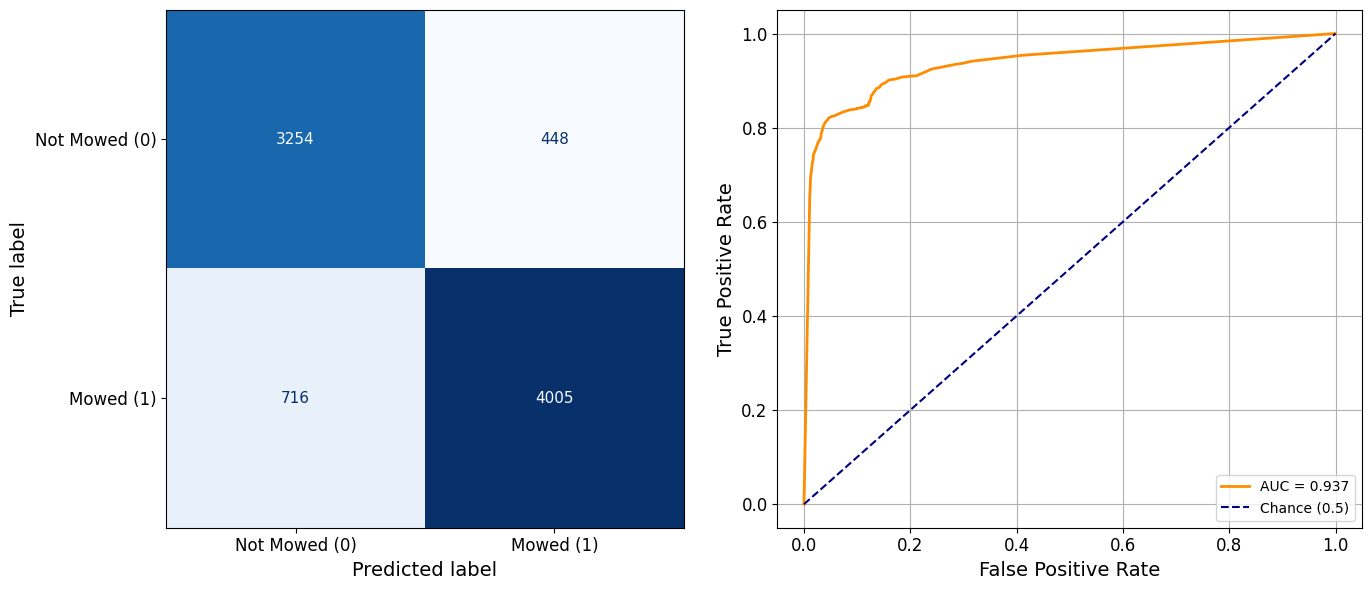

In [15]:
# Train and evaluate Baseline Random Forest
baseline_rf_ndii = train_baseline_rf(X_train_ndii, y_train_ndii, X_test_ndii, y_test_ndii, results_list=model_results, model_alias= "Baseline RF (NDII)")

#### Tuned Random Forest


TRAINING: Tuned Random Forest (GridSearch)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'rf__max_depth': 20, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 500}

--- Evaluation: Tuned RF (NDII) ---
Accuracy: 90.81%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.85      0.97      0.90      3702
    Mowed (1)       0.97      0.86      0.91      4721

     accuracy                           0.91      8423
    macro avg       0.91      0.91      0.91      8423
 weighted avg       0.92      0.91      0.91      8423



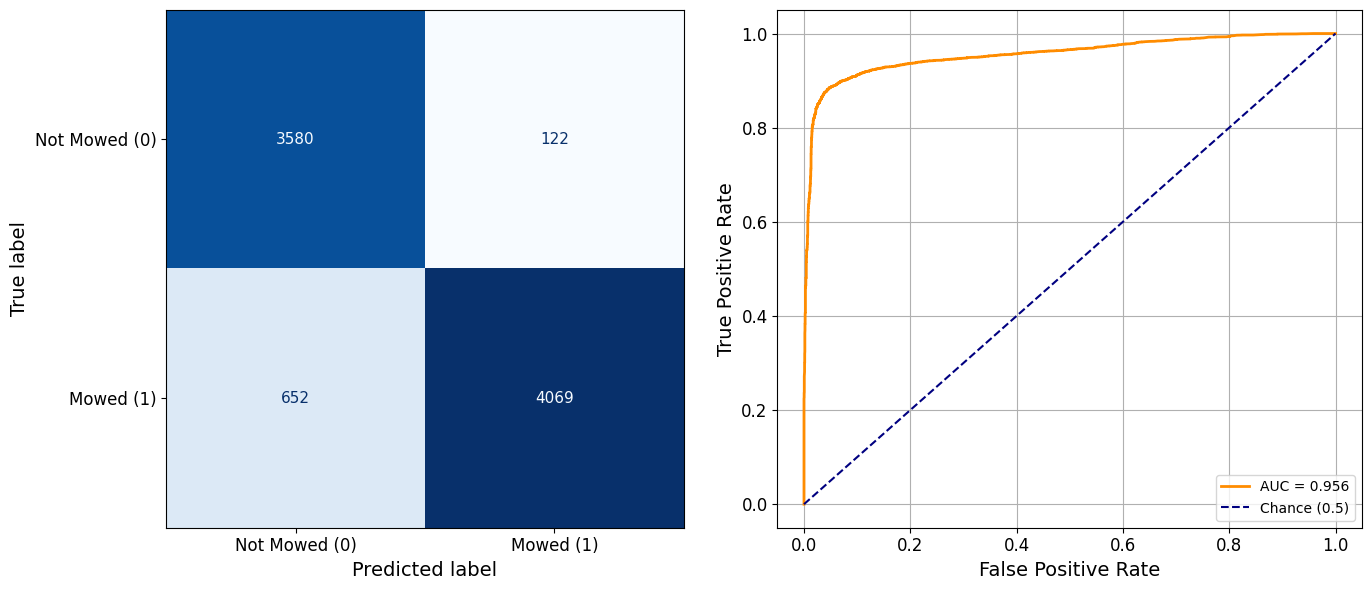

In [16]:
# Train and evaluate Tuned Random Forest
tuned_rf_ndii = train_tuned_rf(X_train_ndii, y_train_ndii, groups_train_ndii, X_test_ndii, y_test_ndii, rf_params, results_list=model_results, model_alias="Tuned RF (NDII)")

#### Basline LGBM


TRAINING: Baseline LightGBM...

--- Evaluation: Baseline LGBM (NDII) ---
Accuracy: 91.20%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.85      0.98      0.91      3702
    Mowed (1)       0.98      0.86      0.92      4721

     accuracy                           0.91      8423
    macro avg       0.91      0.92      0.91      8423
 weighted avg       0.92      0.91      0.91      8423



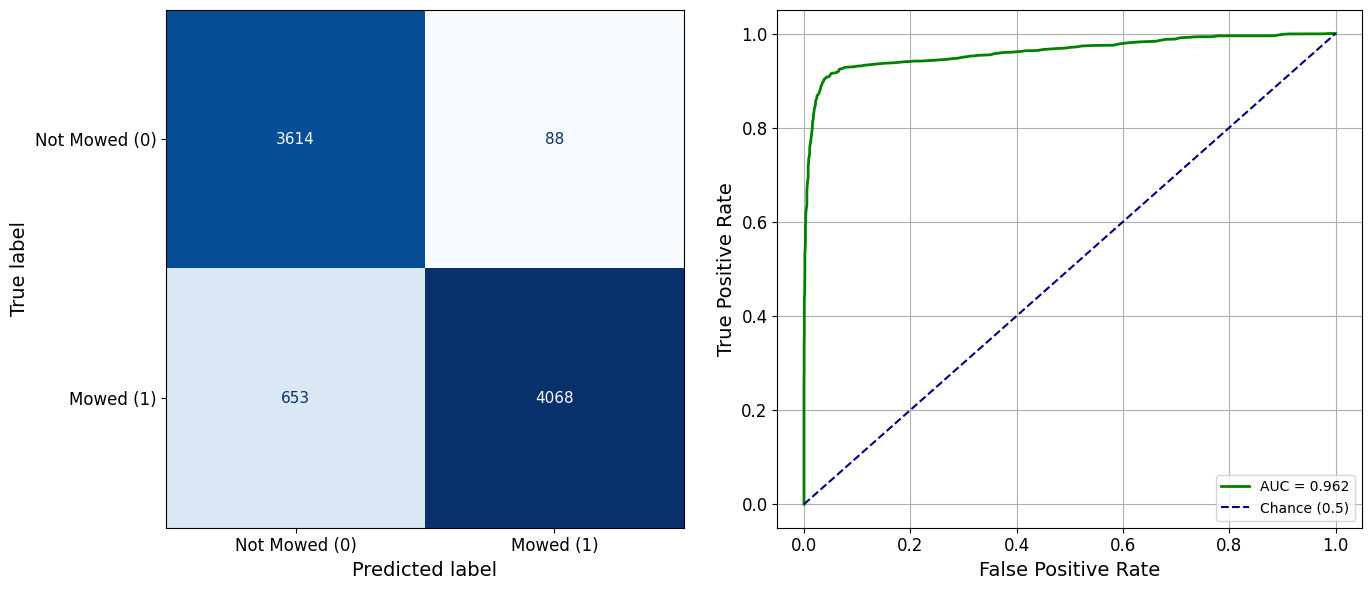

In [ ]:
# Train and evaluate baseline LGBM
baseline_lgbm_ndii = train_baseline_lgbm(X_train_ndii, y_train_ndii, X_test_ndii, y_test_ndii, results_list=model_results, model_alias="Baseline LGBM (NDII)")

#### Tuned LGBM


TRAINING: Tuned LightGBM (GridSearch)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'lgbm__learning_rate': 0.05, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 31}

--- Evaluation: Tuned LGBM (NDII) ---
Accuracy: 91.20%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.85      0.98      0.91      3702
    Mowed (1)       0.98      0.86      0.92      4721

     accuracy                           0.91      8423
    macro avg       0.91      0.92      0.91      8423
 weighted avg       0.92      0.91      0.91      8423



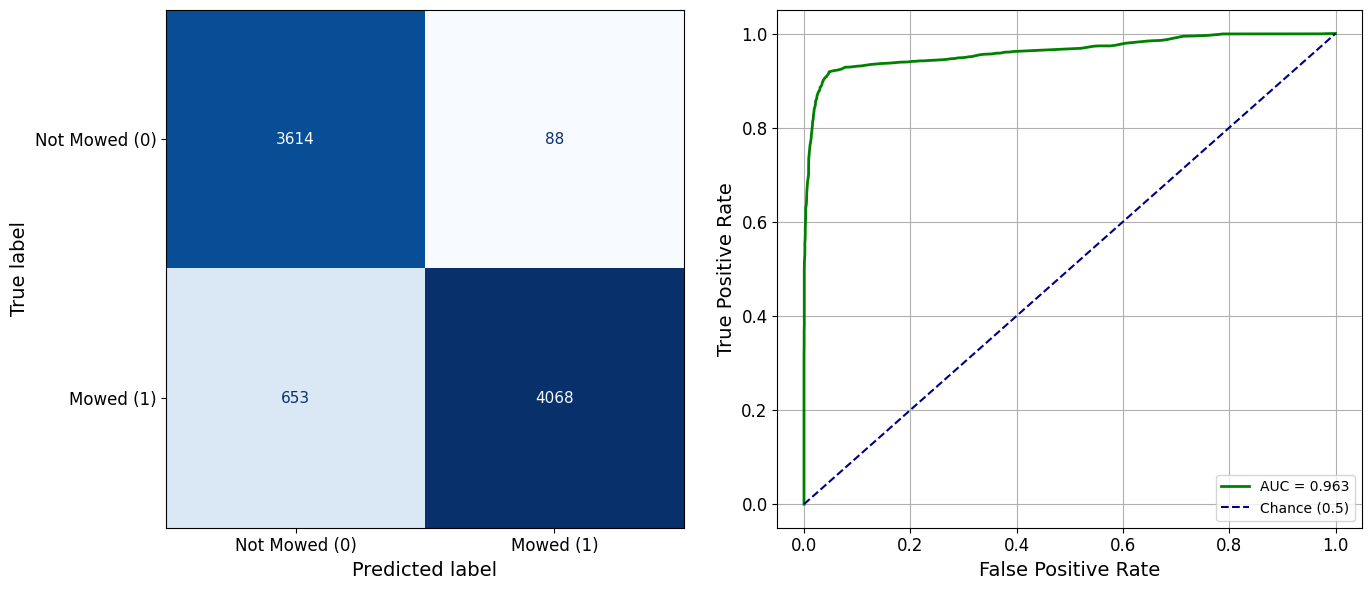

In [18]:
# Train and evaluate Tuned LGBM
tuned_lgbm_ndii = train_tuned_lgbm(X_train_ndii, y_train_ndii, groups_train_ndii, X_test_ndii, y_test_ndii, lgbm_params, results_list=model_results, model_alias="Tuned LGBM (NDII)")

#### Baseline SVM


TRAINING: Baseline SVM...

--- Evaluation: Baseline SVM (NDII) ---
Accuracy: 91.04%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.84      0.98      0.91      3702
    Mowed (1)       0.98      0.86      0.91      4721

     accuracy                           0.91      8423
    macro avg       0.91      0.92      0.91      8423
 weighted avg       0.92      0.91      0.91      8423



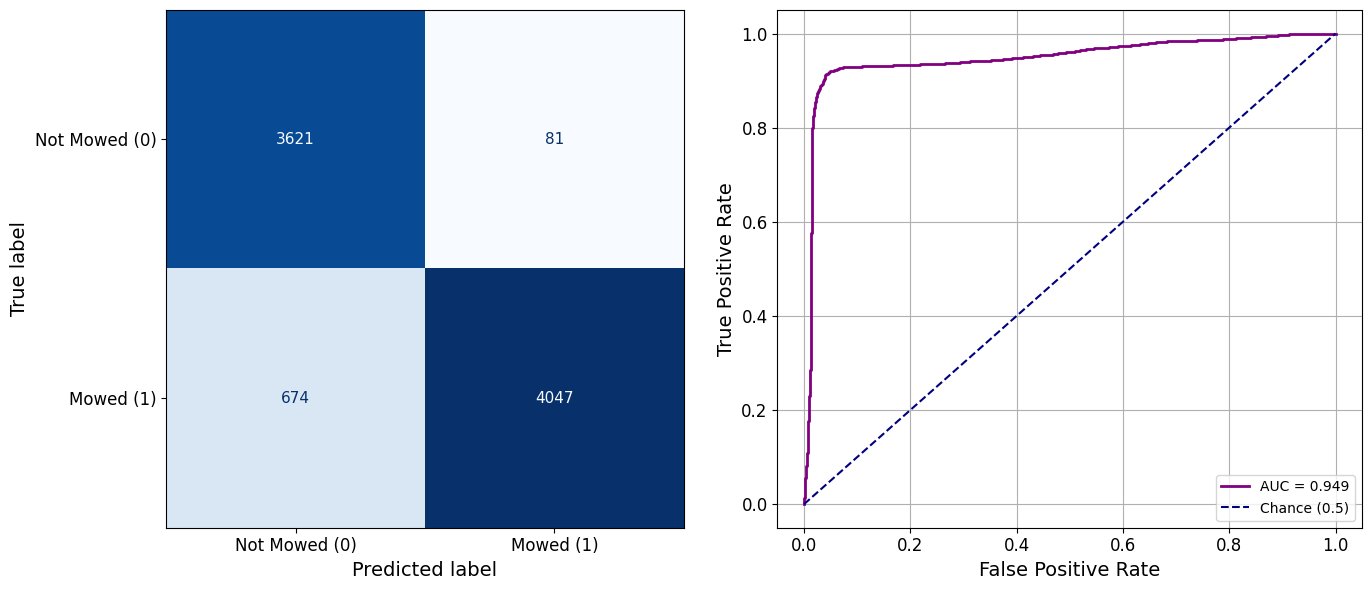

In [ ]:
# Train and evaluate baseline SVM
baseline_svm_ndii = train_baseline_svm(X_train_ndii, y_train_ndii, X_test_ndii, y_test_ndii, results_list=model_results, model_alias="Baseline SVM (NDII)")

#### Tuned SVM


TRAINING: Tuned SVM (GridSearch)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}

--- Evaluation: Tuned SVM (NDII) ---
Accuracy: 90.83%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.84      0.98      0.90      3702
    Mowed (1)       0.98      0.85      0.91      4721

     accuracy                           0.91      8423
    macro avg       0.91      0.92      0.91      8423
 weighted avg       0.92      0.91      0.91      8423



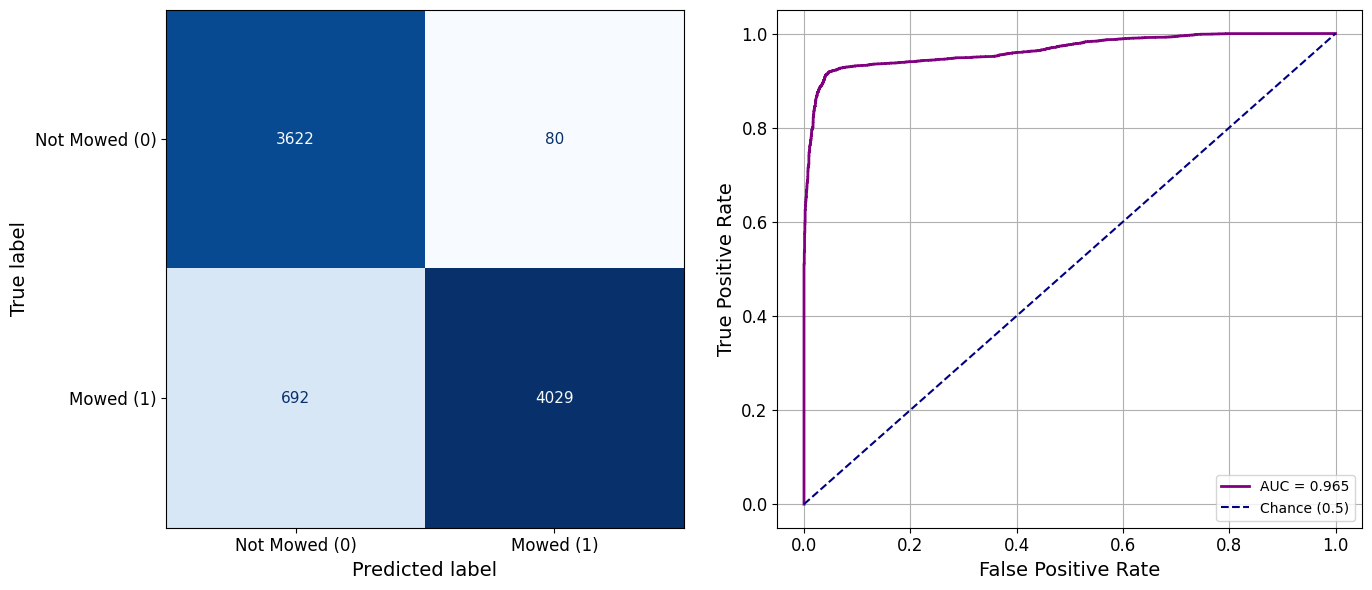

In [ ]:
# # Train and evaluate tuned SVM
tuned_svm_ndii = train_tuned_svm(X_train_ndii, y_train_ndii, groups_train_ndii, X_test_ndii, y_test_ndii, svm_params, results_list=model_results, model_alias="Tuned SVM (NDII)")

---
### ndvi_diff
In this section the same models are tested, using only the second strongest feature "ndvi_diff"

In [ ]:
# Featrue to keep
FEATURES_TO_KEEP_ndvi = ['ndvi_diff']

# Prepare NDVI data
X_train_ndvi, y_train_ndvi, groups_train_ndvi, X_test_ndvi, y_test_ndvi = prepare_data(data, FEATURES_TO_KEEP_ndvi)


--- Preparing Data with 1 Features ---
Training samples: 24945 (50 matches)
Testing samples:  8423 (13 matches)


#### Baseline Random Forest


TRAINING: Baseline Random Forest...

--- Evaluation: Baseline RF (NDVI) ---
Accuracy: 80.93%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.77      0.81      0.79      3702
    Mowed (1)       0.84      0.81      0.83      4721

     accuracy                           0.81      8423
    macro avg       0.81      0.81      0.81      8423
 weighted avg       0.81      0.81      0.81      8423



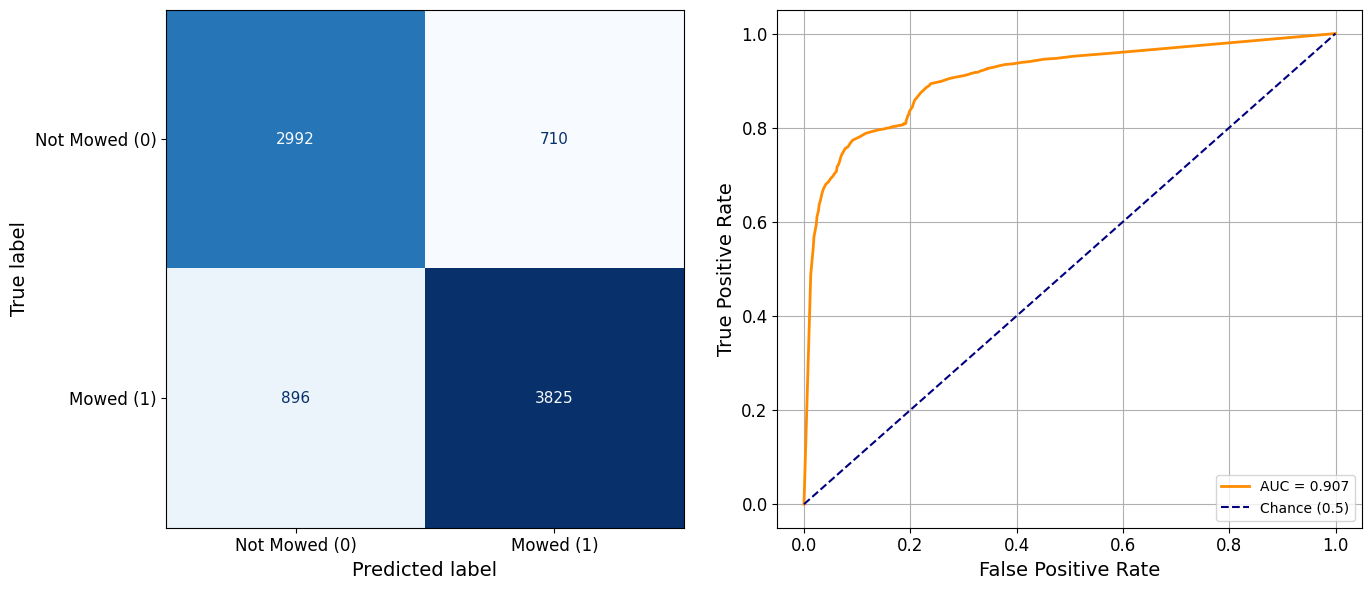

In [ ]:
# Train and evaluate baseline Random Forest
baseline_rf_ndvi = train_baseline_rf(X_train_ndvi, y_train_ndvi, X_test_ndvi, y_test_ndvi, results_list=model_results, model_alias= "Baseline RF (NDVI)")

#### Tuned Random Forest


TRAINING: Tuned Random Forest (GridSearch)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'rf__max_depth': 20, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}

--- Evaluation: Tuned RF (NDVI) ---
Accuracy: 89.64%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.86      0.92      0.89      3702
    Mowed (1)       0.93      0.88      0.90      4721

     accuracy                           0.90      8423
    macro avg       0.89      0.90      0.90      8423
 weighted avg       0.90      0.90      0.90      8423



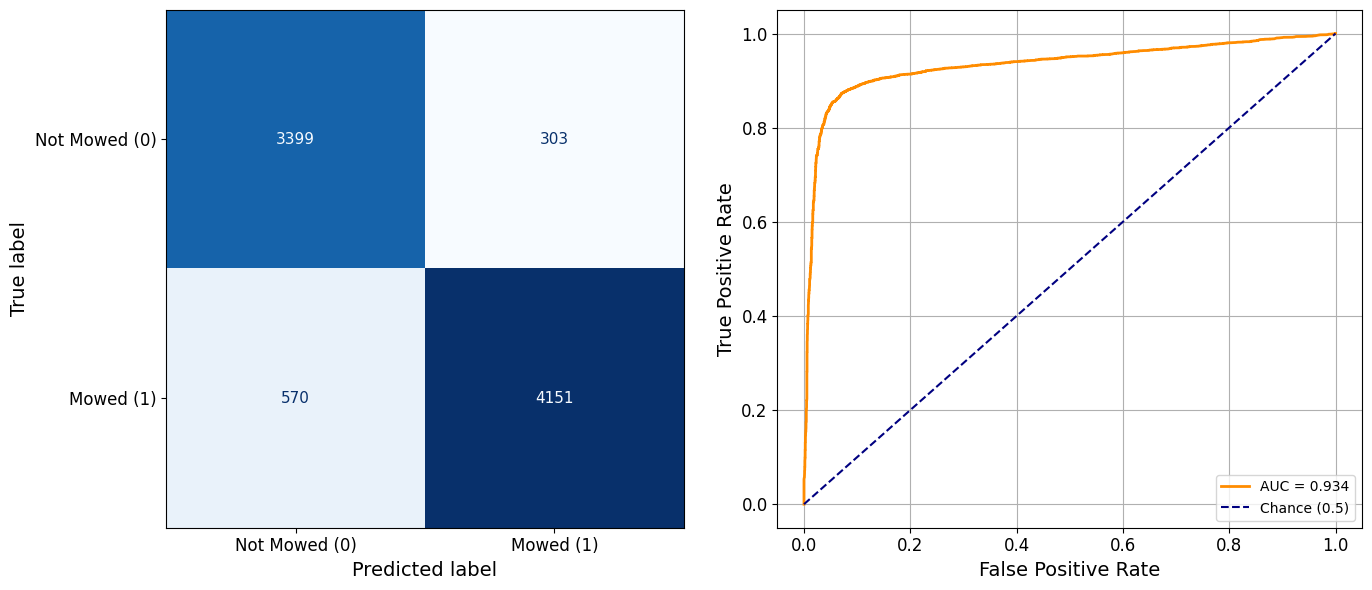

In [ ]:
# Train and evaluate tuned Random Forest
tuned_rf_ndvi = train_tuned_rf(X_train_ndvi, y_train_ndvi, groups_train_ndvi, X_test_ndvi, y_test_ndvi, rf_params, results_list=model_results, model_alias="Tuned RF (NDVI)")

#### Baseline LGBM


TRAINING: Baseline LightGBM...

--- Evaluation: Baseline LGBM (NDVI) ---
Accuracy: 91.43%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.87      0.94      0.91      3702
    Mowed (1)       0.95      0.89      0.92      4721

     accuracy                           0.91      8423
    macro avg       0.91      0.92      0.91      8423
 weighted avg       0.92      0.91      0.91      8423



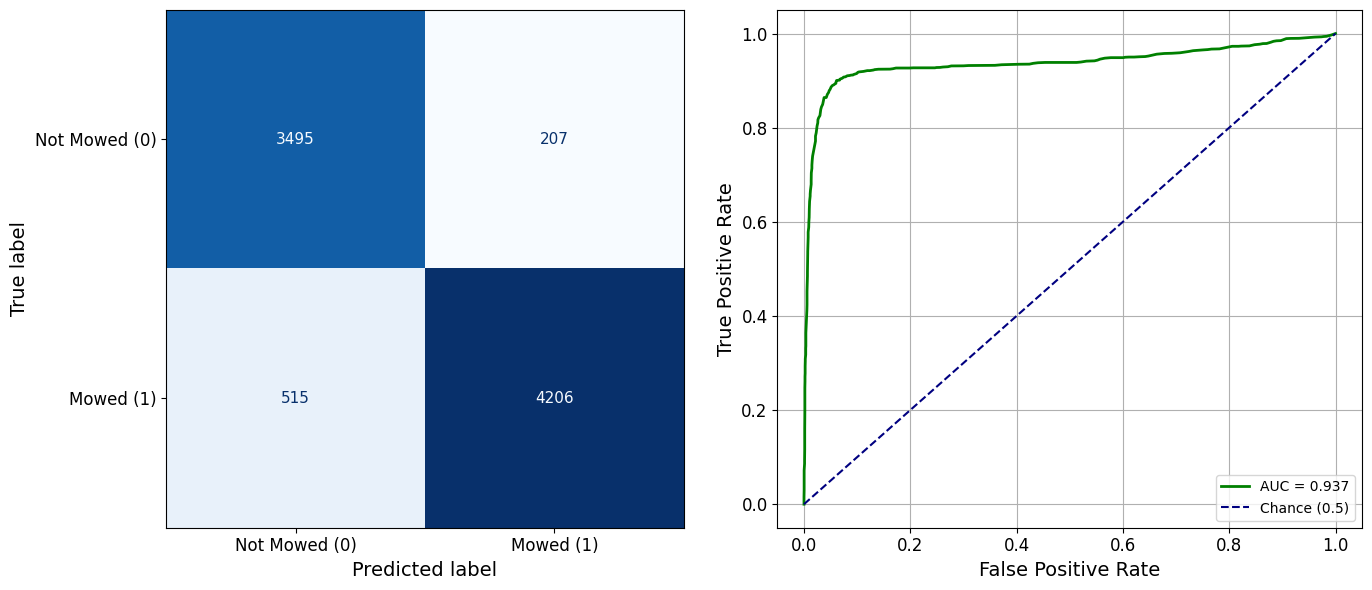

In [ ]:
# Train and evaluate baseline LGBM
baseline_lgbm_ndvi = train_baseline_lgbm(X_train_ndvi, y_train_ndvi, X_test_ndvi, y_test_ndvi, results_list=model_results, model_alias="Baseline LGBM (NDVI)")

#### Tuned LGBM


TRAINING: Tuned LightGBM (GridSearch)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'lgbm__learning_rate': 0.05, 'lgbm__max_depth': -1, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 50}

--- Evaluation: Tuned LGBM (NDVI) ---
Accuracy: 91.46%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.87      0.95      0.91      3702
    Mowed (1)       0.95      0.89      0.92      4721

     accuracy                           0.91      8423
    macro avg       0.91      0.92      0.91      8423
 weighted avg       0.92      0.91      0.91      8423



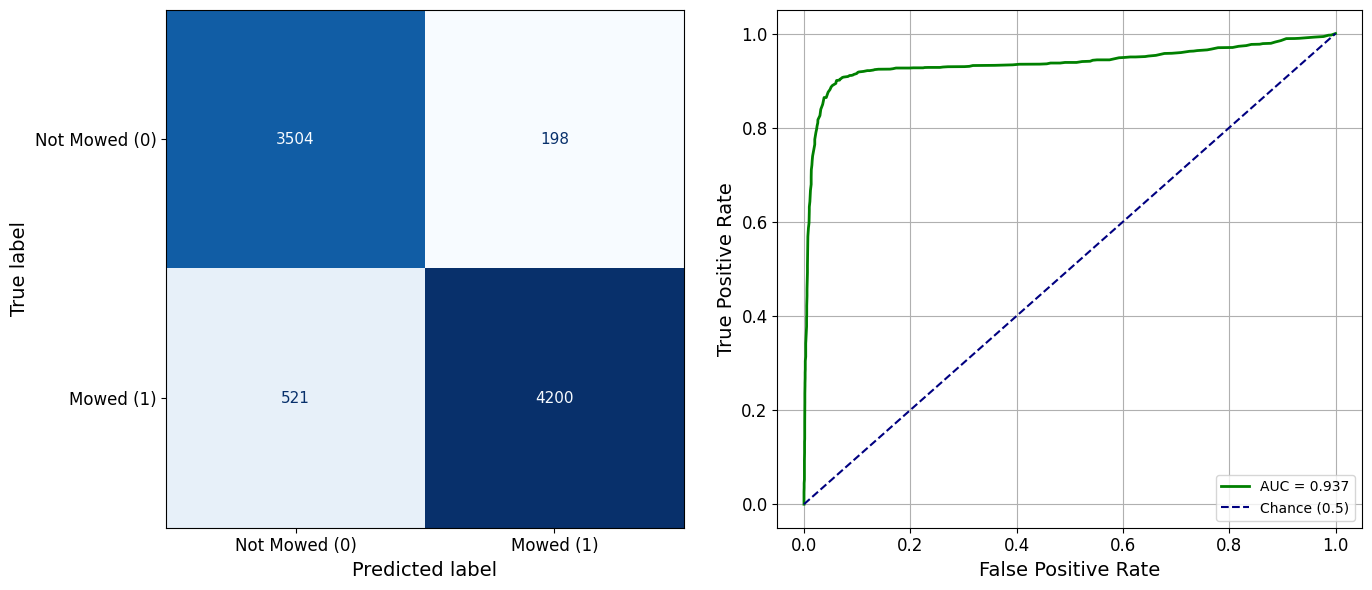

In [ ]:
# Train and evaluate tuned LGBM
tuned_lgbm_ndvi = train_tuned_lgbm(X_train_ndvi, y_train_ndvi, groups_train_ndvi, X_test_ndvi, y_test_ndvi, lgbm_params, results_list=model_results, model_alias="Tuned LGBM (NDVI)")

#### Baseline SVM


TRAINING: Baseline SVM...

--- Evaluation: Baseline SVM (NDVI) ---
Accuracy: 91.86%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.87      0.95      0.91      3702
    Mowed (1)       0.96      0.89      0.92      4721

     accuracy                           0.92      8423
    macro avg       0.92      0.92      0.92      8423
 weighted avg       0.92      0.92      0.92      8423



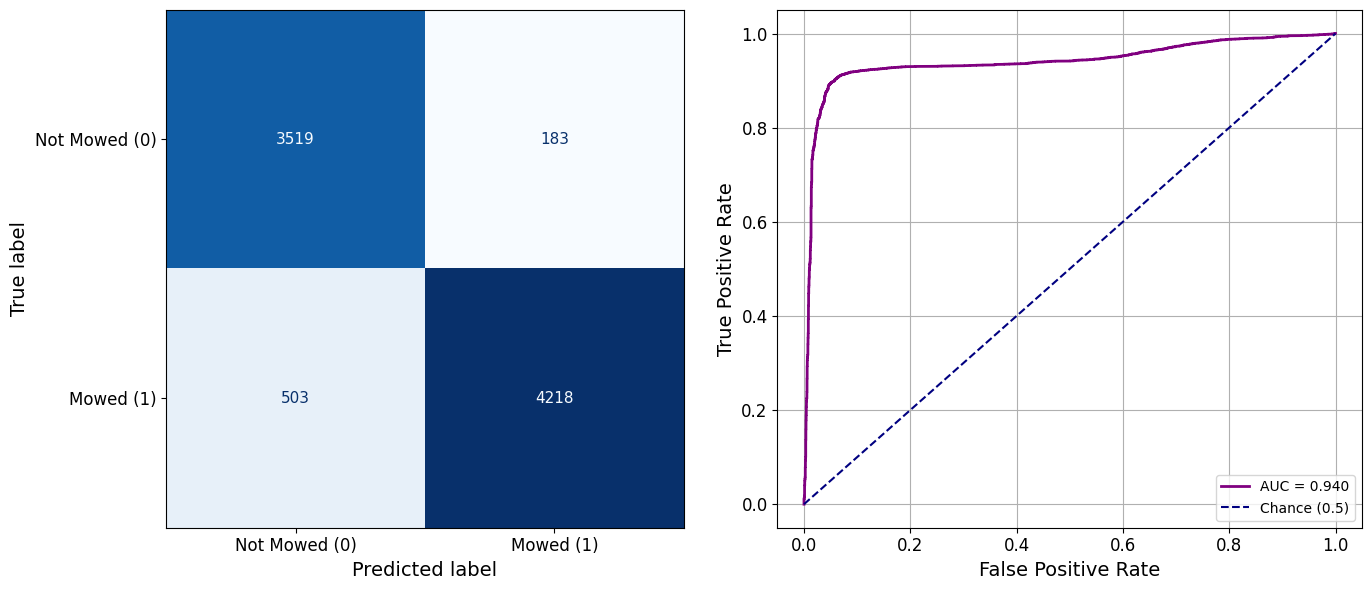

In [ ]:
# Train and evaluate baseline SVM
baseline_svm_ndvi = train_baseline_svm(X_train_ndvi, y_train_ndvi, X_test_ndvi, y_test_ndvi, results_list=model_results, model_alias="Baseline SVM (NDVI)")

#### Tuned SVM


TRAINING: Tuned SVM (GridSearch)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}

--- Evaluation: Tuned SVM (NDVI) ---
Accuracy: 91.36%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.86      0.96      0.91      3702
    Mowed (1)       0.96      0.88      0.92      4721

     accuracy                           0.91      8423
    macro avg       0.91      0.92      0.91      8423
 weighted avg       0.92      0.91      0.91      8423



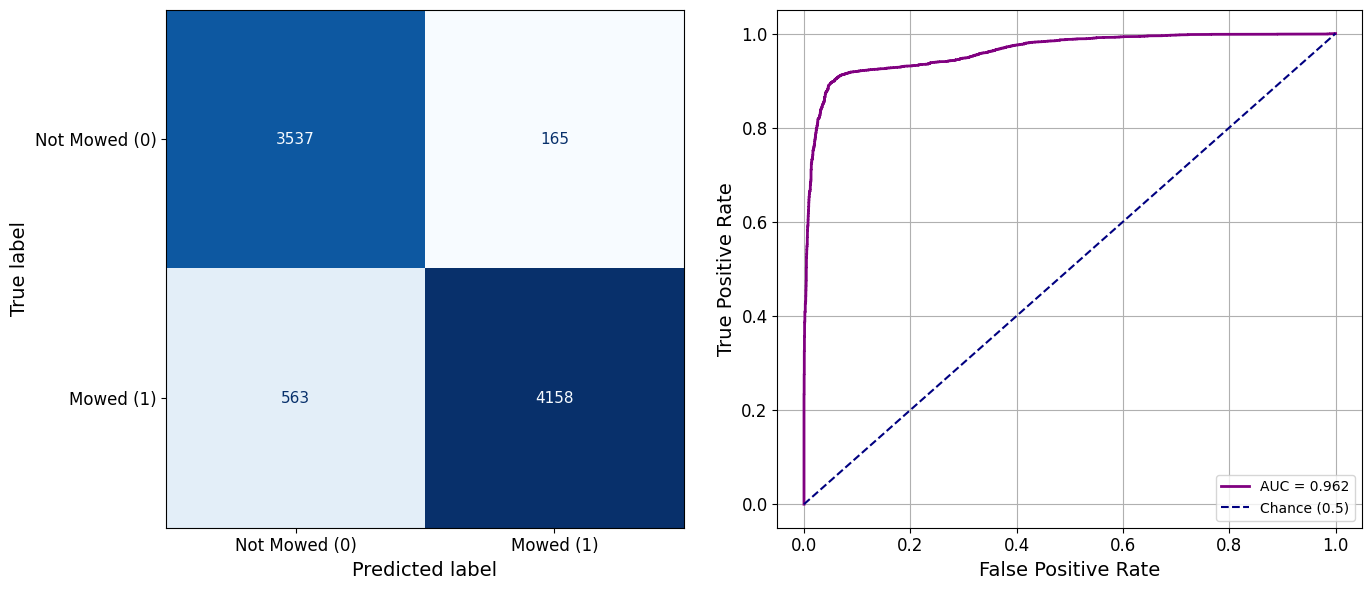

In [ ]:
# Train and evaluate tuned SVM
tuned_svm_ndvi = train_tuned_svm(X_train_ndvi, y_train_ndvi, groups_train_ndvi, X_test_ndvi, y_test_ndvi, svm_params, results_list=model_results, model_alias="Tuned SVM (NDVI)")

---
### Multiple strongest features

To compare model performance between using only the strongest indicator and adding more information from other features, here the same exact model are again trained and evaluated but using the more features. Since the correlation matrix showed that some of the features are strongly correlated, only the stronger of such features is kept.

In [ ]:
FEATURES_TO_KEEP_multi = [
    # Strongest change signals
    'ndii_diff',
    'ndvi_diff',
    'swir_diff',
    'red_diff',
    'nir_diff',

    # Strongest state signals
    'swir_after',
    'ndii_after',
    'evi_after'
]

# Prepare data for multi-feature model
X_train_multi, y_train_multi, groups_train_multi, X_test_multi, y_test_multi = prepare_data(data, FEATURES_TO_KEEP_multi)


--- Preparing Data with 8 Features ---
Training samples: 24945 (50 matches)
Testing samples:  8423 (13 matches)


#### Baseline Random Forest


TRAINING: Baseline Random Forest...

--- Evaluation: Baseline RF (Multi) ---
Accuracy: 89.96%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.84      0.96      0.89      3702
    Mowed (1)       0.96      0.85      0.91      4721

     accuracy                           0.90      8423
    macro avg       0.90      0.91      0.90      8423
 weighted avg       0.91      0.90      0.90      8423



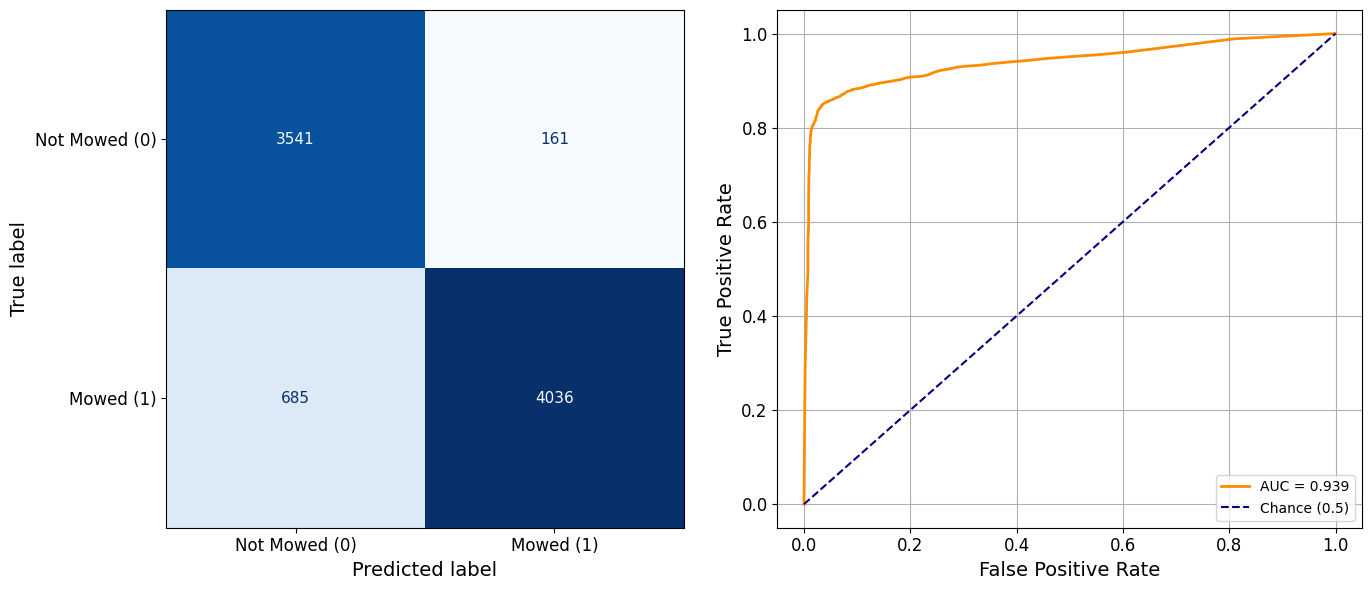

In [ ]:
# Train and evaluate baseline Random Forest
baseline_rf_multi = train_baseline_rf(X_train_multi, y_train_multi, X_test_multi, y_test_multi, results_list=model_results, model_alias= "Baseline RF (Multi)")

#### Tuned Random Forest


TRAINING: Tuned Random Forest (GridSearch)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'rf__max_depth': None, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}

--- Evaluation: Tuned RF (Multi) ---
Accuracy: 90.18%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.84      0.96      0.90      3702
    Mowed (1)       0.96      0.86      0.91      4721

     accuracy                           0.90      8423
    macro avg       0.90      0.91      0.90      8423
 weighted avg       0.91      0.90      0.90      8423



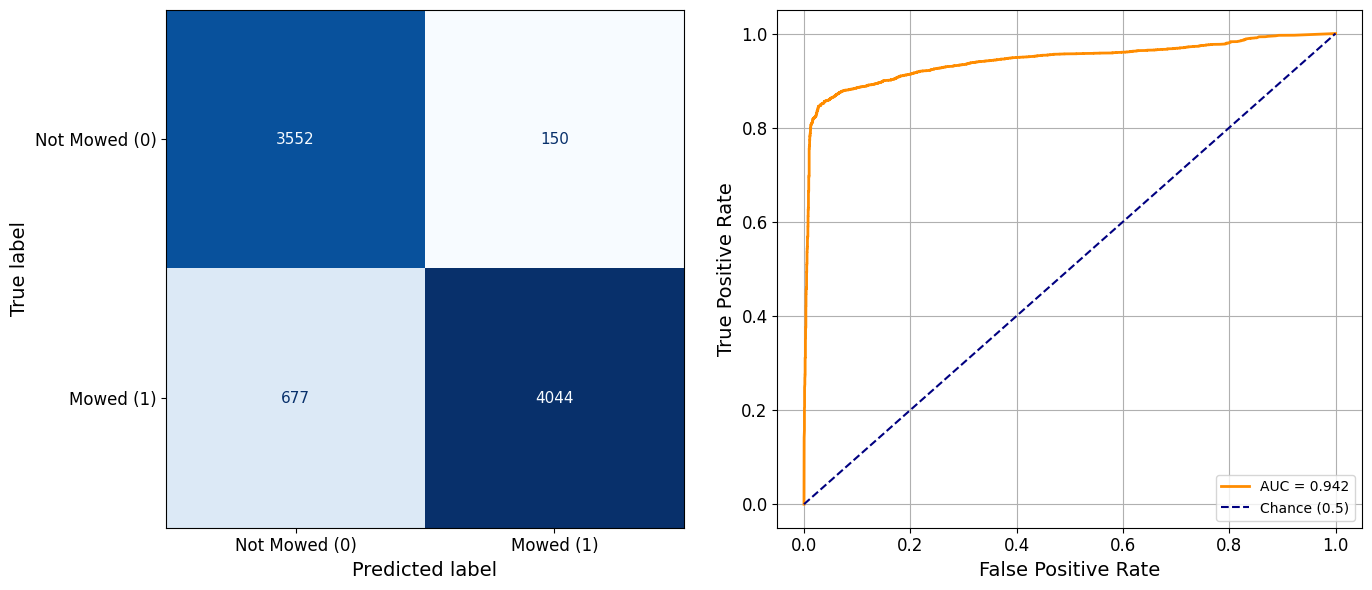

In [ ]:
# Train and evaluate tuned Random Forest
tuned_rf_multi = train_tuned_rf(X_train_multi, y_train_multi, groups_train_multi, X_test_multi, y_test_multi, rf_params, results_list=model_results, model_alias="Tuned RF (Multi)")

#### Baseline LGBM


TRAINING: Baseline LightGBM...

--- Evaluation: Baseline LGBM (Multi) ---
Accuracy: 89.79%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.84      0.95      0.89      3702
    Mowed (1)       0.95      0.86      0.90      4721

     accuracy                           0.90      8423
    macro avg       0.90      0.90      0.90      8423
 weighted avg       0.90      0.90      0.90      8423



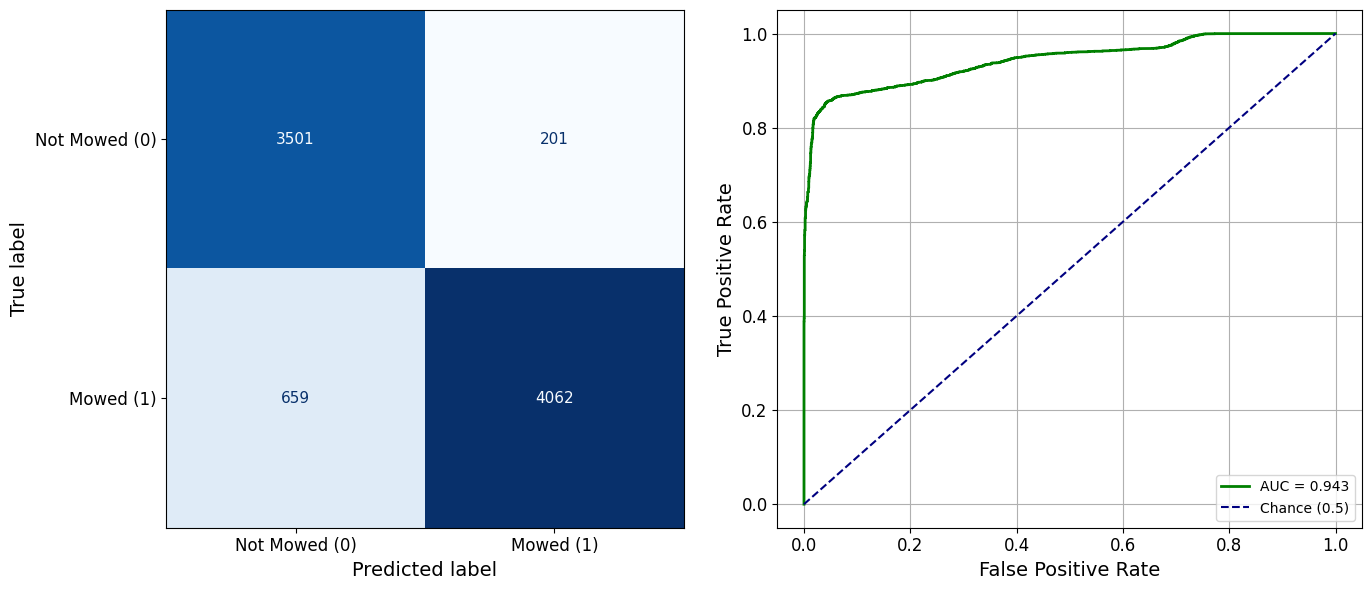

In [ ]:
# Train and evaluate baseline LGBM
baseline_lgbm_multi = train_baseline_lgbm(X_train_multi, y_train_multi, X_test_multi, y_test_multi, results_list=model_results, model_alias="Baseline LGBM (Multi)")

#### Tuend LGBM


TRAINING: Tuned LightGBM (GridSearch)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'lgbm__learning_rate': 0.05, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 31}

--- Evaluation: Tuned LGBM (Multi) ---
Accuracy: 90.09%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.84      0.96      0.89      3702
    Mowed (1)       0.96      0.86      0.91      4721

     accuracy                           0.90      8423
    macro avg       0.90      0.91      0.90      8423
 weighted avg       0.91      0.90      0.90      8423



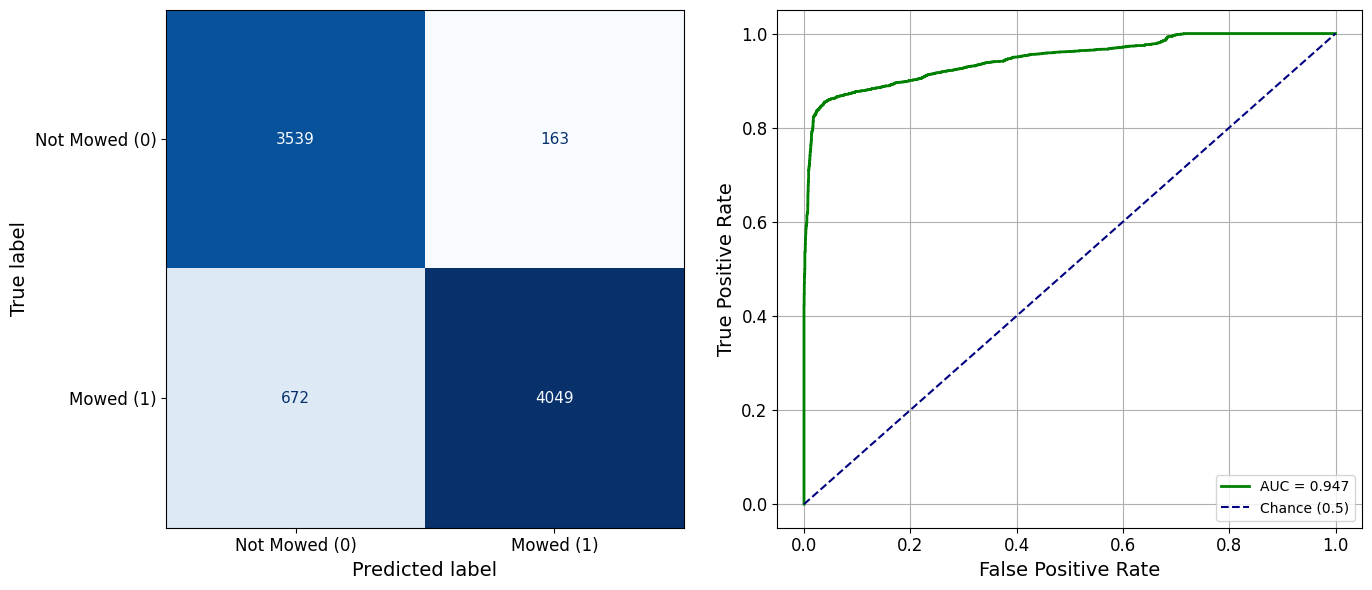

In [ ]:
# Train and evaluate tuned LGBM
tuned_lgbm_multi = train_tuned_lgbm(X_train_multi, y_train_multi, groups_train_multi, X_test_multi, y_test_multi, lgbm_params, results_list=model_results, model_alias="Tuned LGBM (Multi)")

#### Baseline SVM


TRAINING: Baseline SVM...

--- Evaluation: Baseline SVM (Multi) ---
Accuracy: 92.14%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.86      0.98      0.92      3702
    Mowed (1)       0.98      0.88      0.93      4721

     accuracy                           0.92      8423
    macro avg       0.92      0.93      0.92      8423
 weighted avg       0.93      0.92      0.92      8423



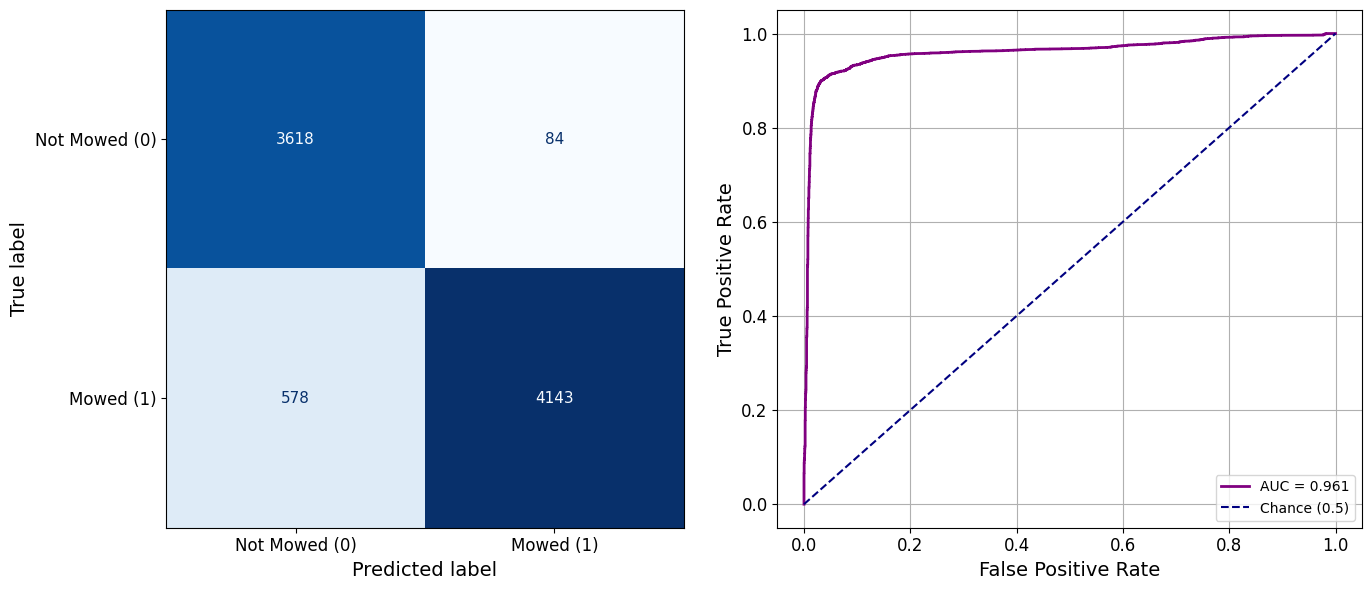

In [ ]:
# Train and evaluate baseline SVM
baseline_svm_multi = train_baseline_svm(X_train_multi, y_train_multi, X_test_multi, y_test_multi, results_list=model_results, model_alias="Baseline SVM (Multi)")

#### Tuned SVM


TRAINING: Tuned SVM (GridSearch)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}

--- Evaluation: Tuned SVM (Multi) ---
Accuracy: 92.12%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.86      0.98      0.92      3702
    Mowed (1)       0.98      0.88      0.93      4721

     accuracy                           0.92      8423
    macro avg       0.92      0.93      0.92      8423
 weighted avg       0.93      0.92      0.92      8423



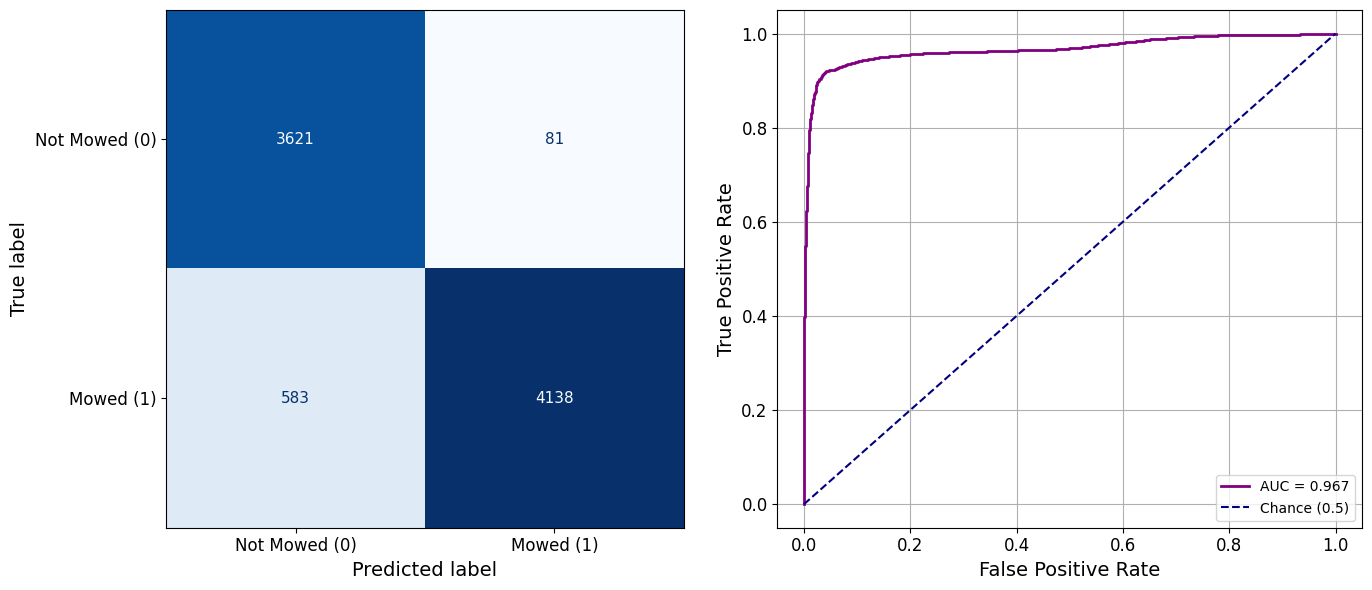

In [ ]:
# Train and evaluate tuned SVM
tuned_svm_multi = train_tuned_svm(X_train_multi, y_train_multi, groups_train_multi, X_test_multi, y_test_multi, svm_params, results_list=model_results, model_alias="Tuned SVM (Multi)")

---
### Hybrid Features

Based on the features combinations run so far it was visible that ndii_diff is clearly the strongest feature. The multi-feature model performed well, but overpredicts alot in the model application (see Notebook "Model_Application.ipynb"). In this final test a set of features is specifically selected and tested: ndii_diff is again chosen, as it shows the strongest impact. The other added features are selected based on their correlation to ndii_diff and the label. The goal was to add information from features that have a weak correlation to the main feature ndii_diff but high correlation with the label.

In [ ]:
FEATURES_TO_KEEP_HYBRID = [
    'ndii_diff',   # Moisture Change (Primary Signal)
    'ndii_after',  # Moisture State (Context)
    'gndvi_diff',  # Greenness Change (Validation)
    'swir_after'   # Structure/Brightness State (Absolute Reference)
]

# Prepare data for hybrid-feature model
X_train_hybrid, y_train_hybrid, groups_train_hybrid, X_test_hybrid, y_test_hybrid = prepare_data(data, FEATURES_TO_KEEP_HYBRID)


--- Preparing Data with 4 Features ---
Training samples: 24945 (50 matches)
Testing samples:  8423 (13 matches)


#### Baseline Random Forest


TRAINING: Baseline Random Forest...

--- Evaluation: Baseline RF (Hybrid) ---
Accuracy: 91.68%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.87      0.96      0.91      3702
    Mowed (1)       0.96      0.88      0.92      4721

     accuracy                           0.92      8423
    macro avg       0.92      0.92      0.92      8423
 weighted avg       0.92      0.92      0.92      8423



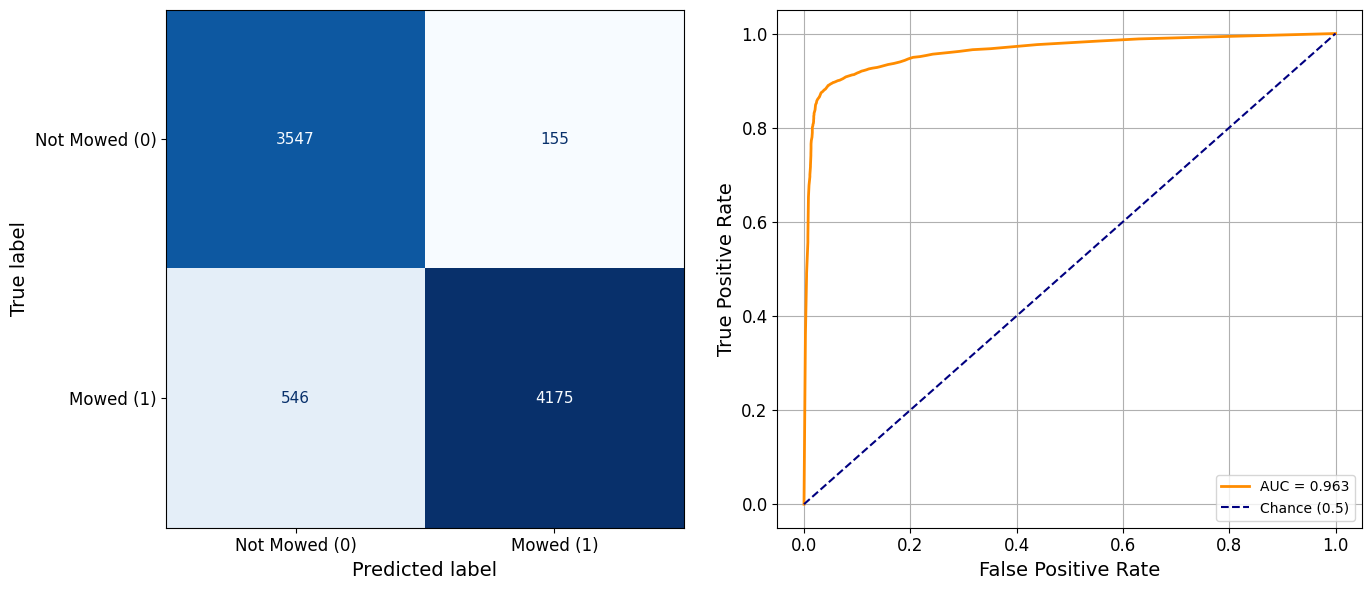

In [ ]:
# Train and evaluate baseline Random Forest
baseline_rf_hybrid = train_baseline_rf(X_train_hybrid, y_train_hybrid, X_test_hybrid, y_test_hybrid, results_list=model_results, model_alias= "Baseline RF (Hybrid)")

#### Tuned Random Forest


TRAINING: Tuned Random Forest (GridSearch)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'rf__max_depth': 20, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 500}

--- Evaluation: Tuned RF (Hybrid) ---
Accuracy: 91.84%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.87      0.96      0.91      3702
    Mowed (1)       0.97      0.88      0.92      4721

     accuracy                           0.92      8423
    macro avg       0.92      0.92      0.92      8423
 weighted avg       0.92      0.92      0.92      8423



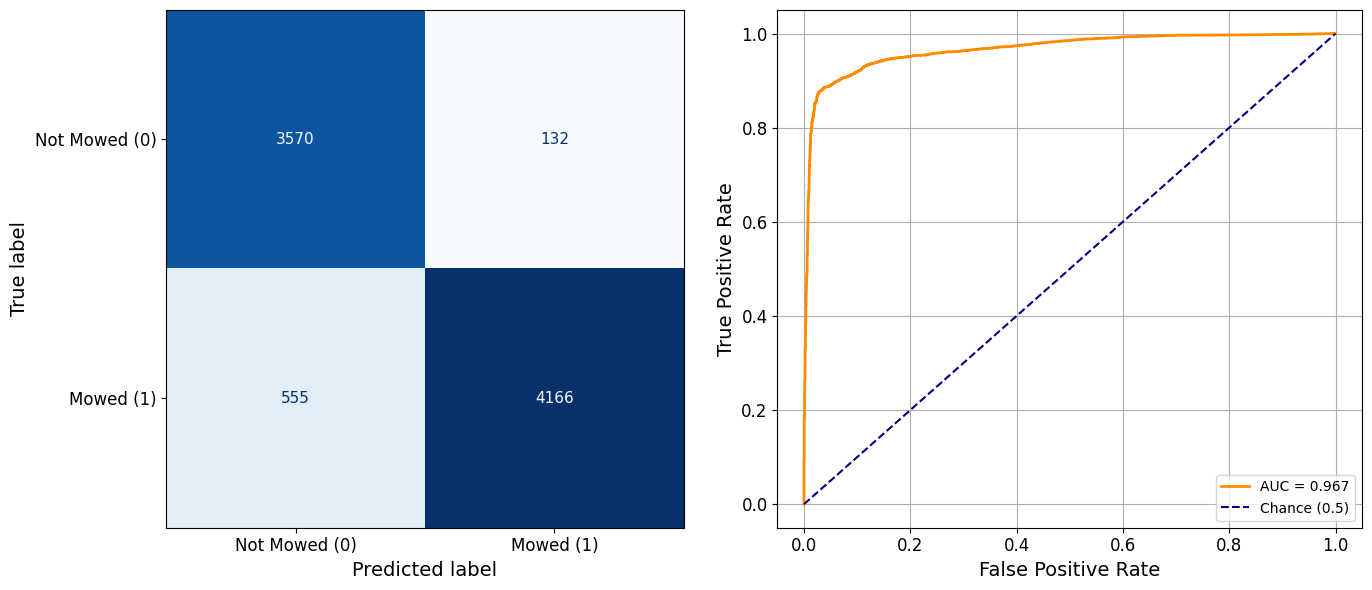

In [ ]:
# Train and evaluate tuned Random Forest
tuned_rf_hybrid = train_tuned_rf(X_train_hybrid, y_train_hybrid, groups_train_hybrid, X_test_hybrid, y_test_hybrid, rf_params, results_list=model_results, model_alias="Tuned RF (Hybrid)")

#### Baseline LGBM


TRAINING: Baseline LightGBM...

--- Evaluation: Baseline LGBM (Hybrid) ---
Accuracy: 91.30%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.87      0.95      0.91      3702
    Mowed (1)       0.96      0.89      0.92      4721

     accuracy                           0.91      8423
    macro avg       0.91      0.92      0.91      8423
 weighted avg       0.92      0.91      0.91      8423



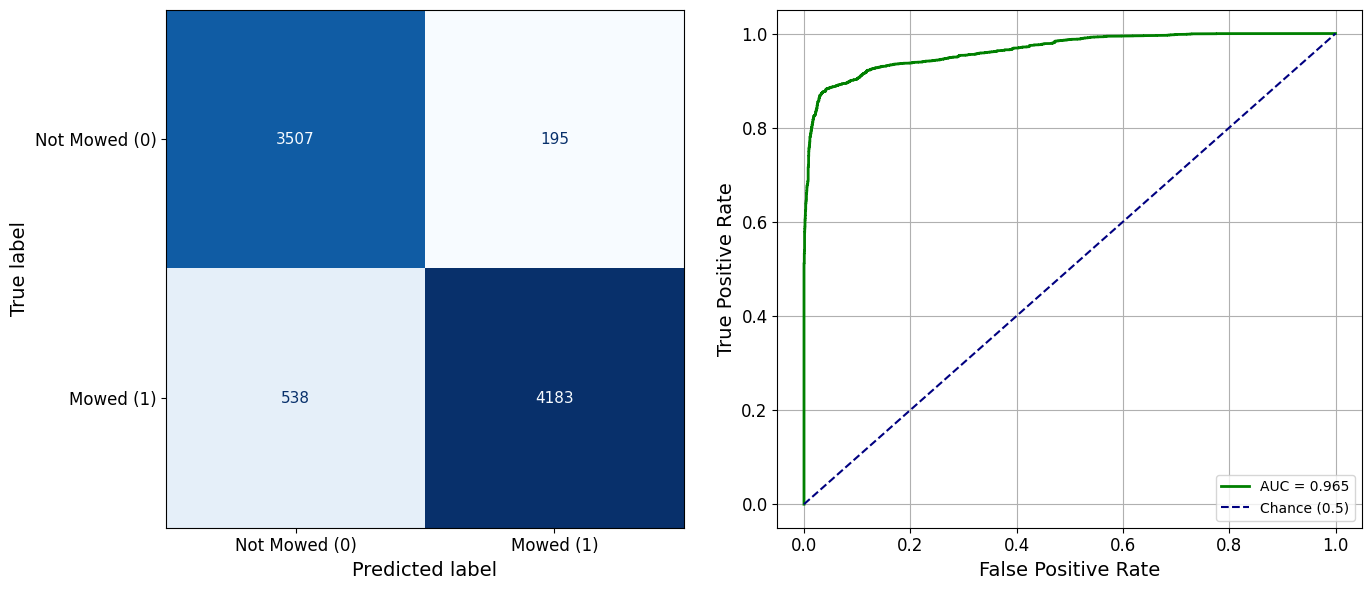

In [ ]:
# Train and evaluate baseline LGBM
baseline_lgbm_hybrid = train_baseline_lgbm(X_train_hybrid, y_train_hybrid, X_test_hybrid, y_test_hybrid, results_list=model_results, model_alias="Baseline LGBM (Hybrid)")

#### Tuned LGBM


TRAINING: Tuned LightGBM (GridSearch)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'lgbm__learning_rate': 0.05, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 31}

--- Evaluation: Tuned LGBM (Hybrid) ---
Accuracy: 91.32%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.87      0.95      0.91      3702
    Mowed (1)       0.96      0.89      0.92      4721

     accuracy                           0.91      8423
    macro avg       0.91      0.92      0.91      8423
 weighted avg       0.92      0.91      0.91      8423



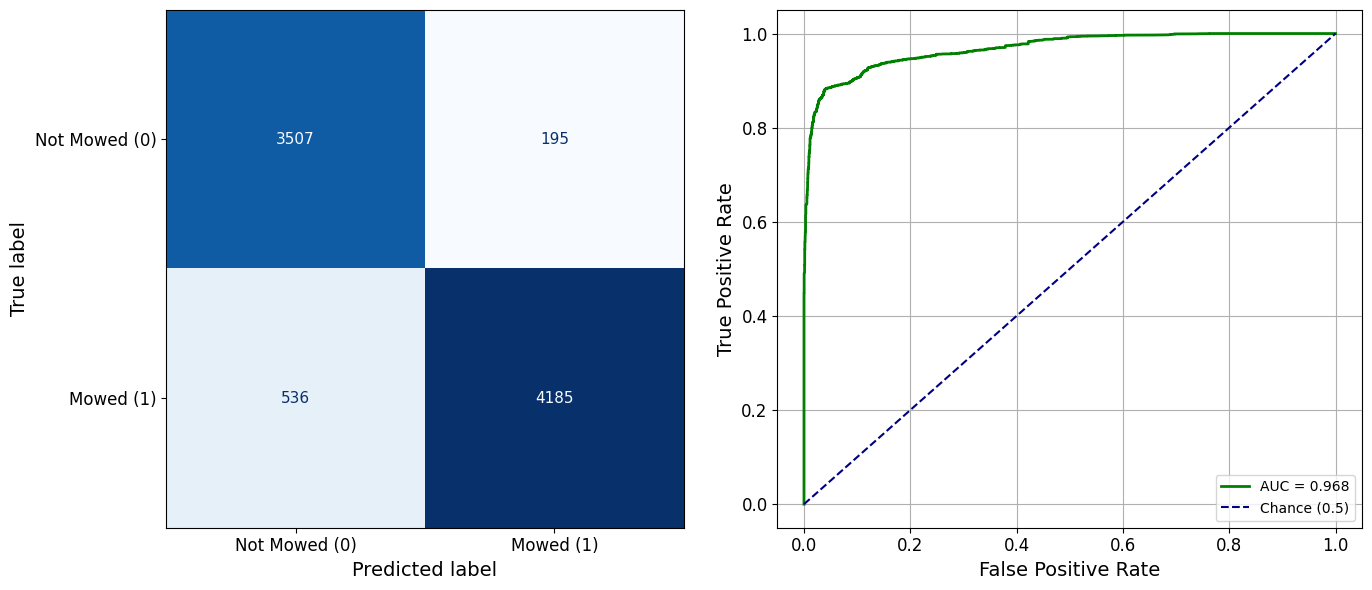

In [ ]:
# Train and evaluate tuned LGBM
tuned_lgbm_hybrid = train_tuned_lgbm(X_train_hybrid, y_train_hybrid, groups_train_hybrid, X_test_hybrid, y_test_hybrid, lgbm_params, results_list=model_results, model_alias="Tuned LGBM (Hybrid)")

#### Baseline SVM


TRAINING: Baseline SVM...

--- Evaluation: Baseline SVM (Hybrid) ---
Accuracy: 91.64%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.85      0.98      0.91      3702
    Mowed (1)       0.98      0.87      0.92      4721

     accuracy                           0.92      8423
    macro avg       0.92      0.92      0.92      8423
 weighted avg       0.92      0.92      0.92      8423



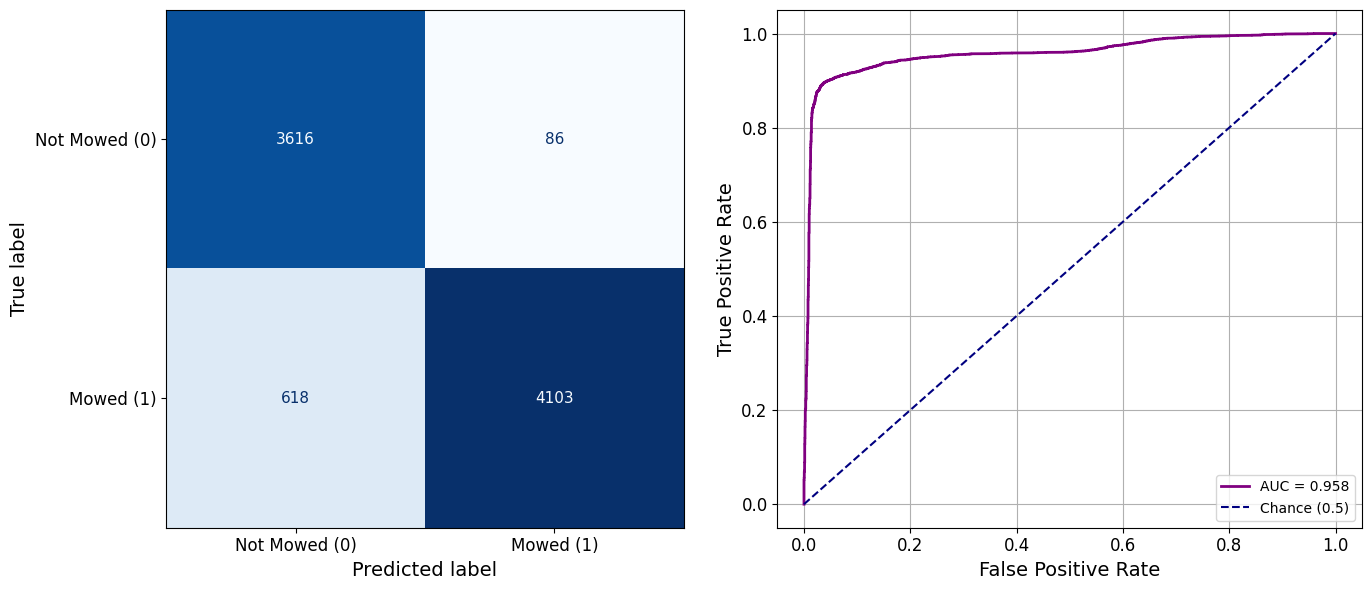

In [ ]:
# Train and evaluate baseline SVM
baseline_svm_hybrid = train_baseline_svm(X_train_hybrid, y_train_hybrid, X_test_hybrid, y_test_hybrid, results_list=model_results, model_alias="Baseline SVM (Hybrid)")

#### Tuned SVM


TRAINING: Tuned SVM (GridSearch)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}

--- Evaluation: Tuned SVM (Hybrid) ---
Accuracy: 91.94%

Classification Report:

               precision    recall  f1-score   support

Not Mowed (0)       0.86      0.98      0.91      3702
    Mowed (1)       0.98      0.87      0.92      4721

     accuracy                           0.92      8423
    macro avg       0.92      0.93      0.92      8423
 weighted avg       0.93      0.92      0.92      8423



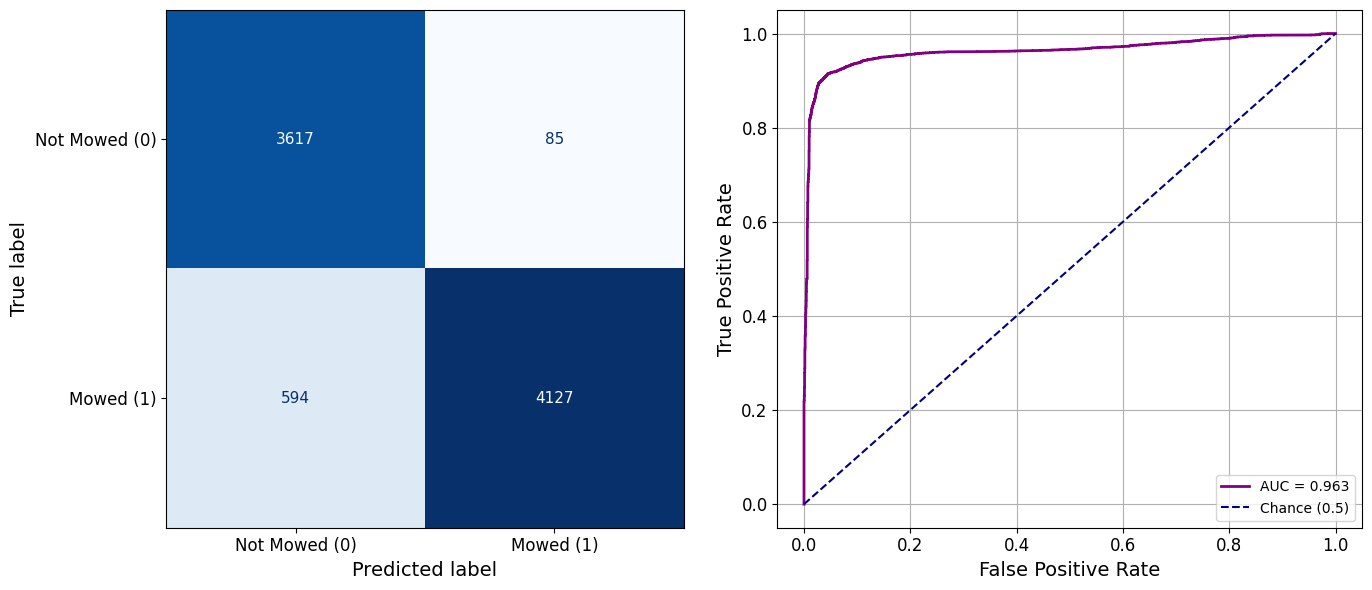

In [ ]:
# Train and evaluate tuned SVM
tuned_svm_hybrid = train_tuned_svm(X_train_hybrid, y_train_hybrid, groups_train_hybrid, X_test_hybrid, y_test_hybrid, svm_params, results_list=model_results, model_alias="Tuned SVM (Hybrid)")

---
### Overview

In [42]:
# Create a DataFrame from the results list
results_df = pd.DataFrame(model_results)
display(results_df)

# Save the results to a CSV file
results_df.to_csv('../data/model_results_summary.csv', index=False)

,Model,Features,Num_Features,Accuracy,Precision,Recall,F1_Score,ROC_AUC,TP,TN,FP,FN
0,Baseline RF (NDII),[ndii_diff],1,0.861807,0.864344,0.861807,0.862202,0.937,4005,3254,448,716
1,Tuned RF (NDII),[ndii_diff],1,0.908109,0.915971,0.908109,0.908446,0.956,4069,3580,122,652
2,Baseline LGBM (NDII),[ndii_diff],1,0.912027,0.920872,0.912027,0.912346,0.962,4068,3614,88,653
3,Tuned LGBM (NDII),[ndii_diff],1,0.912027,0.920872,0.912027,0.912346,0.963,4068,3614,88,653
4,Baseline SVM (NDII),[ndii_diff],1,0.910364,0.920031,0.910364,0.910684,0.949,4047,3621,81,674
5,Tuned SVM (NDII),[ndii_diff],1,0.908346,0.918587,0.908346,0.908669,0.965,4029,3622,80,692
6,Baseline RF (NDVI),[ndvi_diff],1,0.809332,0.810963,0.809332,0.809752,0.907,3825,2992,710,896
7,Tuned RF (NDVI),[ndvi_diff],1,0.896355,0.898751,0.896355,0.896651,0.934,4151,3399,303,570
8,Baseline LGBM (NDVI),[ndvi_diff],1,0.914282,0.917263,0.914282,0.914549,0.937,4206,3495,207,515
9,Tuned LGBM (NDVI),[ndvi_diff],1,0.914638,0.917876,0.914638,0.914911,0.937,4200,3504,198,521


In [ ]:
# Save the best models to a file so they can be applied in the advanced Model application pipeline
models_path = '../models/'

# Models used in the report
joblib.dump(baseline_rf_ndii, models_path + 'baseline_rf_ndii.joblib')
joblib.dump(tuned_svm_ndii, models_path + 'tuned_svm_ndii.joblib')
joblib.dump(tuned_lgbm_hybrid, models_path + 'tuned_lgbm_hybrid.joblib')
joblib.dump(tuned_svm_hybrid, models_path + 'tuned_svm_hybrid.joblib')

# Additional models evaluated
#joblib.dump(baseline_lgbm_ndii, models_path + 'baseline_lgbm_ndii.joblib')
#joblib.dump(baseline_svm_ndii, models_path + 'baseline_svm_ndii.joblib')
#joblib.dump(baseline_svm_ndvi, models_path + 'baseline_svm_ndvi.joblib')
#joblib.dump(tuned_svm_ndvi, models_path + 'tuned_svm_ndvi.joblib')
#joblib.dump(tuned_svm_multi, models_path + 'tuned_svm_multi.joblib')


['../models/tuned_svm_multi.joblib']

---
### Further Analysis

Contrary to expectations, it is only the Random Forest models that perform significantly better when the ndii_diff feature is used rather than the ndvi_diff feature. For the other model types, there is almost no difference, with NDVI performing even slightly better than NDII, but not significantly. The difference in performance when using only ndii_diff compared to using multiple features is very small. Only the baseline random forest model performs significantly worse when using only one feature compared to multiple features. More interestingly, there are notable differences in the confusion matrices. When using only ndii_diff, the number of false positives is smaller than for the same model trained with multiple features. At the same time, the number of false negatives is higher. This finding is analysed more closely in this section for the tuned SVM models (hybrid features vs. ndii_diff only).

In [44]:
# Get predictions from both models
pred_ndii = tuned_svm_ndii.predict(X_test_ndii) 
pred_hybrid = tuned_svm_hybrid.predict(X_test_hybrid) 

In [45]:
# Create a comparison dataframe
df_compare = pd.DataFrame({
    'True_Label': y_test_ndii.values,
    'Pred_Single': pred_ndii,
    'Pred_Hybrid': pred_hybrid    
})

# Analysis 1: "Missed Mows" (False Negatives)
# Where Single got it RIGHT (1), but Multi missed it (0)
missed_by_hybrid = df_compare[
    (df_compare['True_Label'] == 1) & 
    (df_compare['Pred_Single'] == 1) & 
    (df_compare['Pred_Hybrid'] == 0)
]

# Analysis 2: "Saved False Alarms" (False Positives)
# Where Single was WRONG (1), but Multi correctly ignored it (0)
saved_by_hybrid = df_compare[
    (df_compare['True_Label'] == 0) & 
    (df_compare['Pred_Single'] == 1) & 
    (df_compare['Pred_Hybrid'] == 0)
]

print(f"Total Test Samples: {len(df_compare)}")
print("-" * 40)
print("CASE 1: The 'Weak Mows' (Recall Trade-off)")
print(f"  Mows caught by Single (NDII) but missed by Hybrid: {len(missed_by_hybrid)}")
print("  -> These are the weak signals the Hybrid-model is too cautious about.")
print("-" * 40)
print("CASE 2: The 'False Alarms' (Precision Gain)")
print(f"  False alarms triggered by Single (NDII) but filtered by Hybrid: {len(saved_by_hybrid)}")
print("  -> These are the cloud shadows/noise the Hybrid-model successfully ignored.")
print("-" * 40)

Total Test Samples: 8423
----------------------------------------
CASE 1: The 'Weak Mows' (Recall Trade-off)
  Mows caught by Single (NDII) but missed by Hybrid: 46
  -> These are the weak signals the Hybrid-model is too cautious about.
----------------------------------------
CASE 2: The 'False Alarms' (Precision Gain)
  False alarms triggered by Single (NDII) but filtered by Hybrid: 12
  -> These are the cloud shadows/noise the Hybrid-model successfully ignored.
----------------------------------------


In [ ]:
# Conclusion Calculation
if len(saved_by_hybrid) > len(missed_by_hybrid):
    diff = len(saved_by_hybrid) - len(missed_by_hybrid)
    print("CONCLUSION: The Hybrid model is better.")
    print(f"It avoided {len(saved_by_hybrid)} false alarms at the cost of missing {len(missed_by_hybrid)} mows.")
    print(f"Net improvement: +{diff} correct classifications.")
else:
    print("CONCLUSION: The Single-Feature model might be better for pure detection.")

CONCLUSION: The Single-Feature model might be better for pure detection.
